<a href="https://colab.research.google.com/github/RuthKassahun/Melanoma_Classification/blob/main/finetuning_EfficientNet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
from glob import glob
import cv2
import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from keras.applications.efficientnet import EfficientNetB0
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
SIZE = 224
train_images_lbp = []
train_labels_lbp = []
for directory_path in glob.glob("/content/drive/MyDrive/MultiClass_Skin_lesion/train/*"):
    label_lbp_train = directory_path.split("/")[-1]
    label = directory_path.split("/")[-1]
    #print(label_lbp_train)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img1 = cv2.imread(img_path,1) #Reading color images
        img1 = cv2.resize(img1, (SIZE, SIZE)) #Resize images
        arr = np.array(img1) # convert the image to numpy array
        train_images_lbp.append(arr)
        train_labels_lbp.append(label_lbp_train)

train_images_lbp =np.array(train_images_lbp)
trait_labels_lbp =np.array(train_labels_lbp)

In [ ]:
#train_images_lbp.shape

In [ ]:
#trait_labels_lbp.shape

In [4]:
test_images_lbp = []
test_labels_lbp = [] 
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("/content/drive/MyDrive/MultiClass_Skin_lesion/val/*"):
    label_lbp_test = directory_path.split("/")[-1]
    label = directory_path.split("/")[-1]
    #print(label_lbp_test)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img2 = cv2.imread(img_path,1) #Reading color images
        img2 = cv2.resize(img2, (SIZE, SIZE)) #Resize images
        arr = np.array(img2) # convert the image to numpy array
        test_images_lbp.append(arr)
        test_labels_lbp.append(label_lbp_test)

test_images_lbp =np.array(test_images_lbp)
test_labels_lbp =np.array(test_labels_lbp)

In [5]:
test_images_lbp.shape

(1270, 224, 224, 3)

In [6]:
X_train, y_train , X_val, y_val = train_images_lbp,trait_labels_lbp,test_images_lbp,test_labels_lbp

In [ ]:
#X_train.shape

In [ ]:
#X_val.shape

In [ ]:
#y_train.shape

In [ ]:
#y_val.shape

In [7]:
from keras.utils.np_utils import to_categorical

In [8]:
le = preprocessing.LabelEncoder()
le.fit(y_val)
y_val = le.transform(y_val)
le.fit(y_train)
y_train = le.transform(y_train)

In [9]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
#y_val.shape

In [ ]:
#y_train.shape

In [11]:
pre_trained_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
#pre_trained_model = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


74836368/74836368 [==============================] - 4s 0us/step


In [12]:
for layer in pre_trained_model.layers:
    #print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

#print(len(pre_trained_model.layers))

In [14]:
pre_trained_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [15]:
last_layer = pre_trained_model.get_layer('top_activation')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 1280)


In [17]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [ ]:
import tensorflow_addons as tfa

In [ ]:
#model.summary()


In [19]:
train_datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [ ]:
# batch_size = 32
# epochs = 5
# history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
#                               verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
#                               validation_steps=(X_val.shape[0] // batch_size))

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

In [25]:
pre_trained_model.layers[172].name


'block6a_se_reduce'

In [26]:
for layer in pre_trained_model.layers[172:]:
    layer.trainable = True

In [27]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [29]:
batch_size = 32
epochs = 30
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

<ipython-input-29-42a1685c4ca4>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/30
158/158 [==============================] - 71s 341ms/step - loss: 1.6035 - acc: 0.6147 - val_loss: 22.0065 - val_acc: 0.4679 - lr: 1.0000e-04
Epoch 2/30
158/158 [==============================] - 52s 329ms/step - loss: 0.7540 - acc: 0.7135 - val_loss: 0.6325 - val_acc: 0.7740 - lr: 1.0000e-04
Epoch 3/30
158/158 [==============================] - 52s 326ms/step - loss: 0.6363 - acc: 0.7479 - val_loss: 0.5211 - val_acc: 0.8077 - lr: 1.0000e-04
Epoch 4/30
158/158 [==============================] - 51s 321ms/step - loss: 0.5741 - acc: 0.7780 - val_loss: 0.4963 - val_acc: 0.8165 - lr: 1.0000e-04
Epoch 5/30
158/158 [==============================] - 51s 321ms/step - loss: 0.5445 - acc: 0.7939 - val_loss: 0.4834 - val_acc: 0.8229 - lr: 1.0000e-04
Epoch 6/30
158/158 [==============================] - 52s 326ms/step - loss: 0.5090 - acc: 0.8121 - val_loss: 0.5068 - val_acc: 0.8101 - lr: 1.0000e-04
Epoch 7/30
158/158 [==============================] - 51s 324ms/step - loss: 0.4811 - a

In [30]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

40/40 [==============================] - 4s 70ms/step - loss: 0.4238 - acc: 0.9016
Validation: accuracy = 0.901575  ;  loss_v = 0.423792


In [31]:
prediction = model.predict(X_val)

40/40 [==============================] - 3s 56ms/step


In [32]:
y_pred = np.argmax(prediction, axis=1)

In [33]:
np.unique(y_pred)

array([0, 1, 2])

In [40]:
np.unique(test_labels_encoded)

array([0, 1, 2])

In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels_lbp)
test_labels_encoded = le.transform(test_labels_lbp)

In [36]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_pred, test_labels_encoded)
print(kappa)

0.8184112153808847


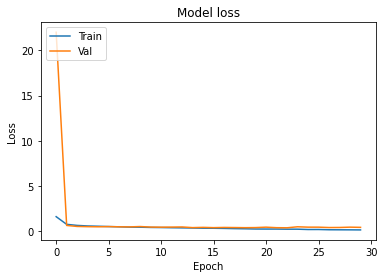

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

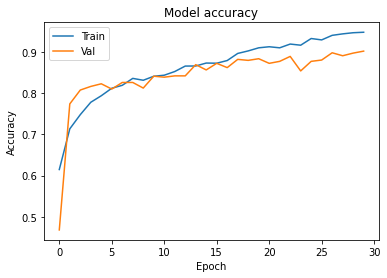

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [39]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
